In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# *DATASET BERUPA 3D KOORDINAT MEDIAPIPE HANDS*

In [2]:
# Konfigurasi dataset
DATA_PATH = 'dataset_hand_pose_V2'
gestures = ["Start_End", "Maju", "Mundur", "Kanan", "Kiri", "Atas", "Bawah", "Putar_kanan", "Putar_kiri", "Undefined"]
num_sequences = 75  # Jumlah sequences per gesture
sequence_length = 1  # Jumlah frame per sequence (hanya 1 frame digunakan)

In [3]:
# Fungsi untuk memuat data dan label
def load_data(data_path, gestures, num_sequences, sequence_length):
    X = []  # Data fitur (landmark tangan)
    y = []  # Label gesture

    for gesture_index, gesture in enumerate(gestures):
        gesture_path = os.path.join(data_path, gesture)
        if not os.path.exists(gesture_path):
            print(f"Warning: Gesture folder not found: {gesture_path}")
            continue

        for seq in range(num_sequences):
            sequence_path = os.path.join(gesture_path, f'sequence_{seq}')
            if not os.path.exists(sequence_path):
                print(f"Warning: Sequence folder not found: {sequence_path}")
                continue

            for frame in range(sequence_length):
                npy_file = os.path.join(sequence_path, f'frame_{frame}.npy')
                if os.path.exists(npy_file):
                    landmarks = np.load(npy_file).reshape(21, 3)
                    X.append(landmarks)
                    y.append(gesture_index)  # Gunakan indeks gesture sebagai label
                else:
                    print(f"Warning: File not found: {npy_file}")

    if len(X) == 0 or len(y) == 0:
        raise ValueError("Dataset is empty or invalid. Please check the dataset structure and files.")

    return np.array(X), np.array(y)

In [4]:
# Memuat dataset
print("Loading dataset...")
X, y = load_data(DATA_PATH, gestures, num_sequences, sequence_length)
print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1:]} features.")

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Loading dataset...
Dataset loaded: 750 samples with (21, 3) features.


Training CNN model...
Epoch 1/75


C:\Users\Ardy Pratama\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2832 - loss: 2.2574 - val_accuracy: 0.2467 - val_loss: 2.2940
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7634 - loss: 0.8395 - val_accuracy: 0.2533 - val_loss: 2.2740
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.5572 - val_accuracy: 0.1933 - val_loss: 2.2658
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8833 - loss: 0.4117 - val_accuracy: 0.1667 - val_loss: 2.2500
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9092 - loss: 0.2968 - val_accuracy: 0.1400 - val_loss: 2.2265
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9349 - loss: 0.1987 - val_accuracy: 0.1667 - val_loss: 2.2038
Epoch 7/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9518 - loss: 0.1739 - val_accuracy: 0.2000 - val_loss: 2.1681
Epoch 8/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9768 - loss: 0.0959 - val_accuracy: 0.3000 - val_loss: 2.1329
Ep

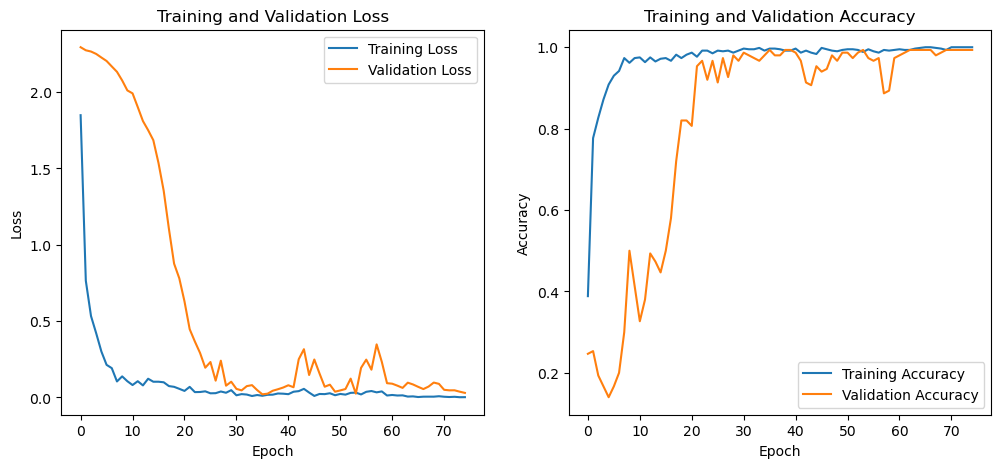


Classification Report (Per-Class Metrics):
             precision    recall  f1-score
Start_End       1.0000  1.000000  1.000000
Maju            0.9375  1.000000  0.967742
Mundur          1.0000  1.000000  1.000000
Kanan           1.0000  1.000000  1.000000
Kiri            1.0000  1.000000  1.000000
Atas            1.0000  1.000000  1.000000
Bawah           1.0000  1.000000  1.000000
Putar_kanan     1.0000  1.000000  1.000000
Putar_kiri      1.0000  1.000000  1.000000
Undefined       1.0000  0.941176  0.969697


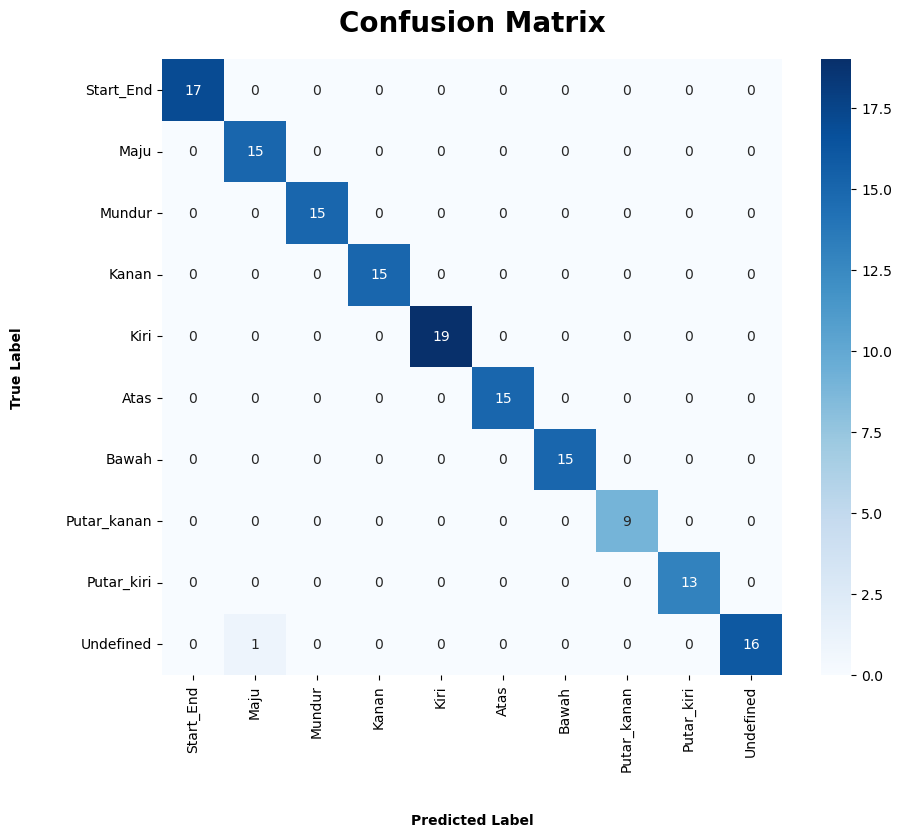

In [5]:
# Model CNN untuk data koordinat 3D tangan
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(21, 3)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(gestures), activation='softmax')  # Output layer sesuai jumlah kelas
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
print("Training CNN model...")
history = model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi
print("Evaluating model...")
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot grafik loss dan akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred, target_names=gestures, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[gestures]  # Filter only gesture rows
print("\nClassification Report (Per-Class Metrics):")
print(report_df[['precision', 'recall', 'f1-score']])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gestures, yticklabels=gestures)
plt.title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.xlabel('Predicted Label', labelpad=30, weight='bold')
plt.ylabel('True Label', labelpad=30, weight='bold')
plt.show()


In [6]:
# Save model
model_path = "model/cnn3d_hand_pose_model_v2_75.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to model/cnn3d_hand_pose_model_v2_75.h5
